# Анализ данных об оптовых продажах аудиотехники

### Соберем датасет с заказами по папкам

Особенность входных данных состоит в том, что файлы для будущих датафреймов лежат разрозненно: в папке `orders` на каждую дату находится отдельная папка, внутри которой - папки отдельных менеджеров. В папке каждого менеджера находится по два csv-файла: `orders.csv` и `order_status.csv`. В папке products каждая под-папка посвящена одному виду аудиотехники, внутри каждой из этих папок - файл `products.csv`. Необходимо собрать три датафрейма на основе этих данных.

### Соберем датасет с заказами по папкам

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import plotly.express as px

In [2]:
# установим настройки по умолчанию для будущих графиков
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(16,6)}
)

In [3]:
os.getcwd()

'/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-savchits/Sergo/pandas_lessons'

In [4]:
# обходим целевую папку с помощью модуля os и собираем датафреймы

root = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-savchits/shared/homeworks/python_ds_miniprojects/final_project/data/'

target_files = ['orders.csv', 'order_status.csv', 'products.csv']
data_files = []

for path, dirs, files in os.walk(root):
    for file in files:
        if file in target_files:
            file_path = os.path.join(path, file)
            data_files.append(file_path)

df_orders = pd.DataFrame()
df_order_status = pd.DataFrame()
df_products = pd.DataFrame()

for i in data_files:
    if 'products' in i:
        products_to_read = pd.read_csv(i)
        products_to_read['category'] = i.split('/')[-2]
        df_products = pd.concat([df_products, products_to_read], ignore_index=True)
    elif '_status' in i:
        order_status_to_read = pd.read_csv(i)
        df_order_status = pd.concat([df_order_status, order_status_to_read], ignore_index=True)
    else:
        orders_to_read = pd.read_csv(i)
        orders_to_read['manager'] = i.split('/')[-2]
        orders_to_read['date'] = i.split('/')[-3]
        df_orders = pd.concat([df_orders, orders_to_read], ignore_index=True)

In [5]:
df_orders.head()

,order_id,product_id,quantity,manager,date
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10


In [6]:
df_order_status.head()

,order_id,client_id,status
0,QPLK-54839036,52,confirmed
1,MAQJ-95867467,84,canceled
2,KHLF-51759445,23,confirmed
3,DALF-47566548,97,confirmed
4,BZHU-92977894,29,canceled


In [7]:
df_products.head()

,id,name,price,category
0,207,"Denon, AVR-S540BT",243.52,AV-ресивер
1,208,"Denon, AVR-X3700H",1305.52,AV-ресивер
2,209,"Denon, AVR-X4700H",1620.21,AV-ресивер
3,210,"Denon, AVR-X6700H",2050.31,AV-ресивер
4,211,"Denon, AVC-X4700H",1496.81,AV-ресивер


### Посмотрим на общую динамику заказов и определим дни, которые выбиваются из общей картины

Посчитаем количество заказов в каждый день и определим день с наибольшим числом заказов.

In [8]:
df_orders['date'] = pd.to_datetime(df_orders['date'], format = '%Y-%m-%d')
orders_by_date = df_orders \
    .groupby('date', as_index = False) \
    .agg({'order_id':'nunique'}) \
    .rename(columns = {'order_id':'order_count'}) \
    .sort_values('order_count', ascending = False)

orders_by_date['days'] = orders_by_date['date'].dt.day_name()
orders_by_date.head(1)

,date,order_count,days
13,2024-03-14,34,Thursday


Построим график с количеством заказов по дням и определим, заметна ли в данных сезонность.

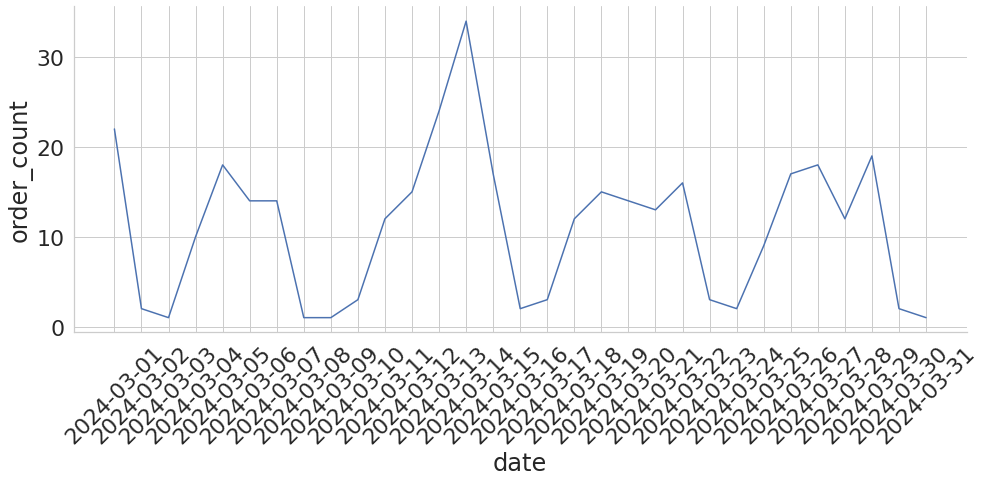

In [9]:
sns.lineplot(data = orders_by_date, x = 'date', y = 'order_count')
plt.xticks(rotation=45)
plt.xticks(orders_by_date["date"])
sns.despine()

Наблюдаем регулярность в динамике заказов: по выходным их почти нет. Также в данных заметен еще один аномальный день: 8 марта 2024 года, пятница. Обычно по пятницам у нас больше 10 заказов, но в эту - всего 1. Это может быть связано с тем, что это был выходной и праздничный день одновременно

Но почему резко подскочили заказы 14 числа? Нужно подробнее изучить этот день. Начнем со статусов заказа.

Добавим к данным о заказах информацию об их статусах. Общий датафрейм назовем `order_status`.

In [10]:
orders_status = df_orders.merge(df_order_status, on='order_id')
orders_status.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-savchits/Sergo/orders_status.csv', index=False)

In [11]:
orders_status.head()

,order_id,product_id,quantity,manager,date,client_id,status
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed


Посмотрите на количество и соотношение подтвержденных и отмененных заказов.

In [12]:
orders_status.status.value_counts(normalize=True).round(2)

confirmed    0.89
canceled     0.11
Name: status, dtype: float64

Посчитаем количество подтвержденных и отмененных заказов на каждую дату. Определим, в какой день не было ни одного подтвержденного заказа. Для этого сделаем сводную таблицу, где в строках будут даты, в колонках — стутасы заказов, а значения — число заказов с этим статусом в определенную дату. Пропуски заполним нулями.

In [13]:
data_status = orders_status \
    .groupby(['date', 'status'], as_index = False) \
    .agg({'order_id':'nunique'}) \
    .pivot(columns = 'status', index = 'date', values = 'order_id') \
    .fillna(0)

In [14]:
data_status.query('confirmed == 0')

status,canceled,confirmed
date,,
2024-03-09,1.0,0.0


Видим, что ни одного заказа не было подтверждено 9 марта 2024 года.

Построим график с заказами по дням в разбивке по статусу заказа. Посмотрим подробнее на день с наибольшим числом заказов (вместе и подтвержденных, и отменных), который мы определили ранее, и на день, предшествующий ему.

In [15]:
stats = orders_status \
    .groupby(['date', 'status'], as_index = False) \
    .agg({'order_id':'nunique'}) \
    .rename(columns={'order_id':'orders'})
stats['date'] = stats['date'].dt.strftime('%d-%m-%Y') 

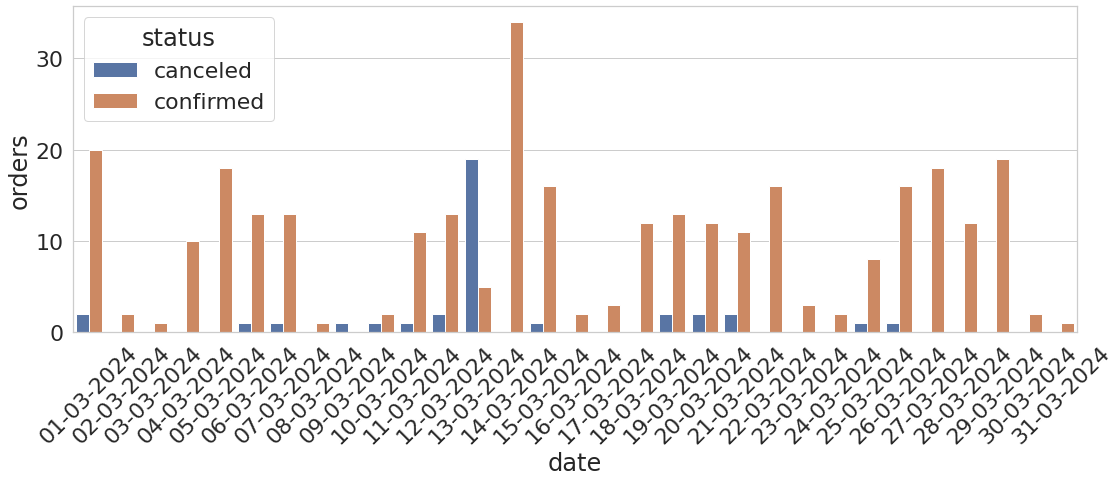

In [16]:
# Ваш код здесь
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(data = stats, x='date', y='orders', hue='status')
ax.tick_params(axis='x', labelrotation=45)

Видим, что в день с наибольшим числом заказов было много успешно оформленных заказов, а вот в день, предшествующий дню с наибольшим числом заказов, отмен было больше, чем подтверждений.

Наиболее правдоподобной будет гипотеза, что у нас произошел сбой в работе CRM системы, который не позволил клиентам подтвердить заказ. В результате все созданные в первый день заказы автоматически отменились, поэтому клиентам пришлось оформлять их повторно на следующий день, и почти половина заказов повторяет вчерашние.

Чтобы это проверить, сравним заказы, отмененные 13 числа, и заказы, подтвержденные 14-го. У них будут совпадать сразу несколько параметров: клиент, менеджер, количество уникальных товаров в заказе и общее число товаров в штуках. Но номера заказов будут разными.

In [17]:
df_1 = orders_status.query('date == "2024-03-13" and status == "canceled"') \
    .groupby(['order_id', 'manager', 'client_id'], as_index=False) \
    .agg({'product_id': pd.Series.nunique, 'quantity': 'sum'})

In [18]:
df_2 = orders_status.query('date == "2024-03-14" and status == "confirmed"') \
    .groupby(['order_id', 'manager', 'client_id'], as_index=False) \
    .agg({'product_id': pd.Series.nunique, 'quantity': 'sum'})

In [19]:
df_1.merge(df_2, on=['manager', 'client_id', 'product_id', 'quantity'])

,order_id_x,manager,client_id,product_id,quantity,order_id_y
0,AFIH-00611801,Алексей Саксофонов,43,11,192,FDEB-71487438
1,BBFJ-27674101,Ксения Балалайкина,73,14,294,UETB-44283966
2,CLBQ-63032648,Виктор Тромбонов,60,13,205,IECD-18739530
3,CYJY-07359557,Екатерина Тарелкина,56,13,316,WNMY-98871151
4,GHGB-88045656,Ксения Балалайкина,7,4,42,JUGG-73806170
5,JEIF-69283221,Виктор Тромбонов,94,15,207,EPBF-14743479
6,JQQO-28609300,Виктор Тромбонов,93,15,252,OWZC-14247946
7,KJJS-03491897,Алексей Саксофонов,66,18,399,GRCH-73394464
8,MIGZ-68487439,Алексей Саксофонов,51,17,325,BCMM-97072924
9,NBIO-35476164,Виктор Тромбонов,95,14,319,NFML-87752700


In [20]:
16 / 34

0.47058823529411764

47 процентов заказов были сформированы повторно. Это значит, что новости скорее плохие: ничего эстраординарного 14 марта наш отдел продаж не сделал, а резкий скачок заказов обусловлен сбоем CRM-системы.

### Посчитаем ключевые метрики, посмотрим на их динамику и составим небольшой отчет

Вторая особенность наших данных состоит в том, что в них цена единицы товара указана в долларах США, а метрики требуется посчитать в рублях. В нашем распоряжении – отдельный текстовый файл с курсом доллара за определенный период на каждую дату. Откроем его и прочитаем в отдельный датафрейм.

In [21]:
usd_rate = open('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-savchits/Sergo/txt_files/usd_rate.txt').readlines()

In [22]:
data_to_dataframe = [[usd.split(',')[0], usd.split(',')[1]] for usd in usd_rate]

In [23]:
currency_rate_data = pd.DataFrame(data_to_dataframe, columns=['date', 'currency_rate'])

In [24]:
currency_rate_data.astype({'currency_rate': 'float'}).describe().round(2)

,currency_rate
count,31.00
mean,91.70
std,0.75
min,90.34
25%,91.02
50%,91.87
75%,92.37
max,92.78


In [25]:
currency_rate_data.currency_rate = currency_rate_data.currency_rate.astype(float)

Объединим все датафреймы в общий df_full и посчитаем общую выручку в рублях (только по подтвержденным заказам)

In [26]:
df_products = df_products.rename(columns={'id': 'product_id'})

In [27]:
currency_rate_data.date = pd.to_datetime(currency_rate_data.date)

In [28]:
df_full = orders_status.merge(df_products, on='product_id')


In [29]:
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,name,price,category
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,"Heco, Ambient 33F",290.74,Настенная акустика
1,YQDE-00869611,489,10,Алексей Саксофонов,2024-03-12,20,confirmed,"Heco, Ambient 33F",290.74,Настенная акустика
2,KBOO-97036112,489,18,Алексей Саксофонов,2024-03-19,24,confirmed,"Heco, Ambient 33F",290.74,Настенная акустика
3,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,"JBL, Control 28-1",301.85,Настенная акустика
4,PZUZ-70017989,594,18,Надежда Гармошкина,2024-03-01,33,confirmed,"JBL, Control 28-1",301.85,Настенная акустика


In [30]:
new_df = df_full.merge(currency_rate_data, on='date').query('status == "confirmed"')

In [31]:
new_df.head()

,order_id,product_id,quantity,manager,date,client_id,status,name,price,category,currency_rate
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,"JBL, Control 28-1",301.85,Настенная акустика,90.7493
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493


In [32]:
new_df['revenue'] = new_df.quantity * new_df.price * new_df.currency_rate

In [33]:
new_df.revenue.sum().round(2)

2038231821.56

Посчитаем средний чек.

In [34]:
round(new_df.revenue.sum() / new_df.order_id.nunique(), 2)

6596219.49

Посмотрим на их динамику внутри месяца: построим графики выручки, среднего чека и числа заказов на каждый день.

In [35]:
average_chek_today = new_df.groupby('date', as_index=False).agg({'revenue': 'sum', 'order_id': pd.Series.nunique}) 

In [36]:
average_chek_today['average_chek'] = average_chek_today.revenue / average_chek_today.order_id

In [37]:
average_chek_today.head()

,date,revenue,order_id,average_chek
0,2024-03-01,1.554118e+08,20,7.770588e+06
1,2024-03-02,1.197167e+07,2,5.985834e+06
2,2024-03-03,2.548418e+06,1,2.548418e+06
3,2024-03-04,6.404993e+07,10,6.404993e+06
4,2024-03-05,8.952724e+07,18,4.973735e+06


In [38]:
average_chek_today.date = average_chek_today.date.dt.strftime('%Y-%m-%d')

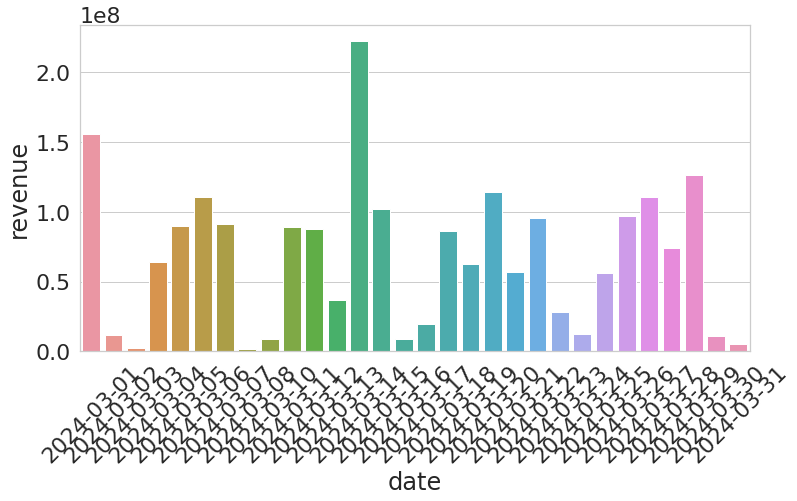

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data = average_chek_today[['date', 'revenue']], x='date', y='revenue')
ax.tick_params(axis='x', labelrotation=45)

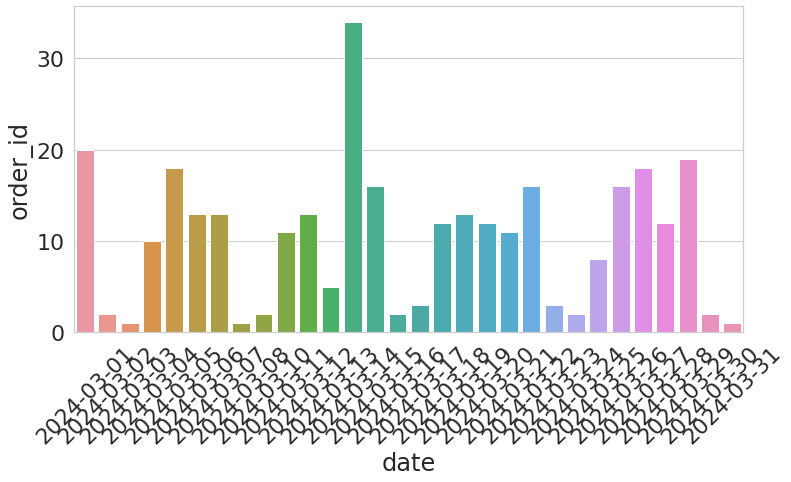

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data = average_chek_today[['date', 'order_id']], x='date', y='order_id')
ax.tick_params(axis='x', labelrotation=45)

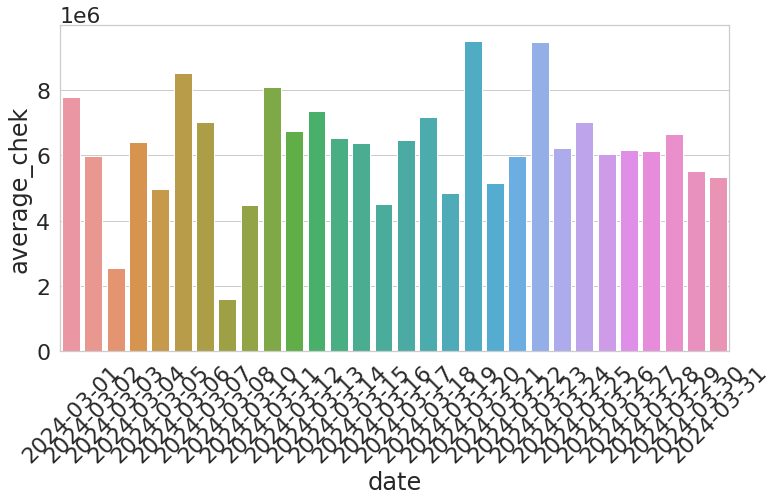

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data = average_chek_today[['date', 'average_chek']], x='date', y='average_chek')
ax.tick_params(axis='x', labelrotation=45)

Видим следующие особенности динамики:

1) число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)

2) средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла)

3) в день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение

4) с течением времени выручка то увеличивается, то уменьшается

5) на протяжении всего месяца средний чек то увеличивается, то уменьшается

### Проанализируем интерес клиентов к брендам

Теперь попробуем разобраться, какие бренды востребованы среди клиентов, а какие — нет. Для этого сформируем новую колонку.

In [42]:
df_full['brand'] = df_full.name.apply(lambda x: x.split(',')[0])

Посмотрим сколько всего уникальных брендов представлено в данных

In [43]:
df_full.brand.nunique()

121

Определим, какой бренд принес наибольшую выручку.

In [44]:
top_brand = df_full.merge(currency_rate_data, on='date')

In [45]:
top_brand['revenue'] = top_brand.currency_rate * top_brand.price * top_brand.quantity

In [46]:
top_brand \
    .query("status == 'confirmed'") \
    .groupby('brand', as_index = False) \
    .agg({'revenue':'sum', 'order_id':'nunique'}) \
    .sort_values('revenue', ascending = False) \
    .head(1)

,brand,revenue,order_id
46,JBL,2.665961e+08,264


У одних брендов большинство товаров востребовано клиентами, а у других — клиенты заказывают только небольшую часть товаров, а остальные зря занимают виртуальную «полку» в перечне товаров. Необходимо определить, какие бренды редко попадают в заказы, хотя товаров таких брендов на самом деле много.

Начнем с того, что определим, сколько товаров ни разу не было заказано.

In [47]:

confirmed_orders = list(df_full.query('status == "confirmed"').product_id.unique())


In [48]:
def func(x):
    if x in confirmed_orders:
        return 'yes'
    else:
        return 'no'
        

In [49]:
df_products['is_in_orders'] = df_products.product_id.apply(lambda x: func(x))

In [50]:
df_products.is_in_orders.value_counts()

yes    1180
no      497
Name: is_in_orders, dtype: int64

Примерно треть товаров не была заказана ни разу. Посмотрим на эти данные в разрезе по брендам. Если доля ни разу не заказанных товаров у бренда была больше половины от всех продаваемых товаров, то будем считать, что они "простаивают". В расчеты не включим те бренды, которые представлены малым числом товаров (до 15).

In [51]:
df_products['brand'] = df_products.name.apply(lambda x: x.split(',')[0])

In [52]:
data_1 = df_products.groupby(['brand', 'is_in_orders'], as_index=False). agg({'product_id': pd.Series.nunique}).rename(columns={'product_id': 'products'})

In [53]:
data_1.head()

,brand,is_in_orders,products
0,AKG,no,6
1,AKG,yes,5
2,ART,yes,1
3,ASUS,no,1
4,ASUS,yes,2


In [54]:
data_2 = pd.pivot_table(data_1, values='products', index='brand',
                       columns='is_in_orders')

In [55]:
data_3 = data_2.fillna(0).reset_index()
data_3.head()

is_in_orders,brand,no,yes
0,AKG,6.0,5.0
1,ART,0.0,1.0
2,ASUS,1.0,2.0
3,Adam Audio,1.0,0.0
4,Amazon,0.0,4.0


In [56]:
data_3['summa'] = data_3.no + data_3.yes

In [57]:
data_3['ratio'] = data_3.no / data_3.summa

In [58]:
data_3.query('summa > 15 and ratio > 0.5')

is_in_orders,brand,no,yes,summa,ratio
32,Dali,49.0,18.0,67.0,0.731343
60,KEF,54.0,28.0,82.0,0.658537
77,Marantz,19.0,3.0,22.0,0.863636
94,Pioneer,70.0,33.0,103.0,0.679612


### Составим отчет по продажам менеджеров

Для каждого менеджера посчитаем количество подтвержденных заказов и какую выручку они принесли, переведем расчеты в процентное соотношение к общему числу заказов и общей выручке, чтобы оценить вклад того или иного менеджера.

In [59]:
manager_performance = new_df[['order_id', 'manager', 'status', 'revenue']]

manager_perf_review = manager_performance \
    .groupby(['manager','status'], as_index = False) \
    .agg({'order_id':'nunique', 'revenue':'sum'}) \
    .query('status=="confirmed"') \
    .rename(columns = {'order_id':'orders'}) \
    .sort_values('revenue', ascending = False)

manager_perf_review['revenue_ratio'] = round(manager_perf_review.revenue / manager_perf_review.revenue.sum() * 100, 2)
manager_perf_review['orders_ratio'] = round(manager_perf_review.orders / manager_perf_review.orders.sum() * 100, 2)
manager_perf_review

,manager,status,orders,revenue,revenue_ratio,orders_ratio
9,Маргарита Камертонова,confirmed,48,3.473886e+08,17.04,15.53
4,Виктор Тромбонов,confirmed,50,3.188999e+08,15.65,16.18
8,Максим Барабанов,confirmed,40,2.401478e+08,11.78,12.94
5,Владимир Ударников,confirmed,31,2.084865e+08,10.23,10.03
0,Алексей Саксофонов,confirmed,27,1.953435e+08,9.58,8.74
7,Ксения Балалайкина,confirmed,27,1.817621e+08,8.92,8.74
6,Екатерина Тарелкина,confirmed,28,1.781576e+08,8.74,9.06
10,Надежда Гармошкина,confirmed,21,1.347836e+08,6.61,6.80
1,Анастасия Дудкина,confirmed,20,1.234504e+08,6.06,6.47
2,Антон Скрипкин,confirmed,7,5.150268e+07,2.53,2.27


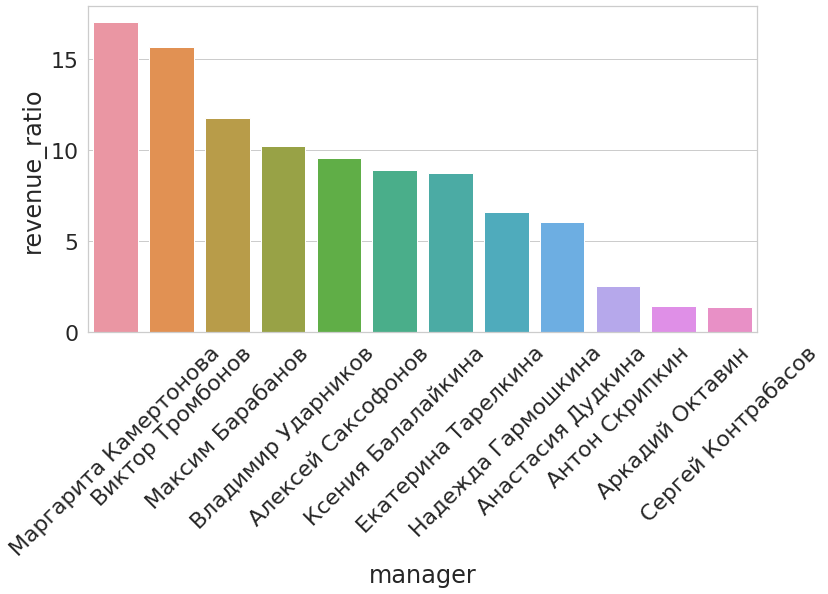

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data =manager_perf_review[['manager', 'revenue_ratio']], x='manager', y='revenue_ratio')
ax.tick_params(axis='x', labelrotation=45)

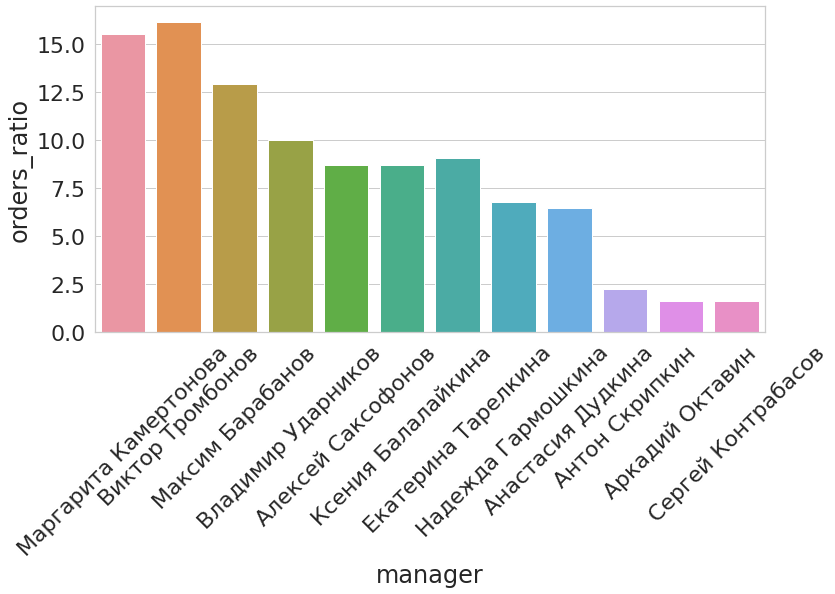

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data =manager_perf_review[['manager', 'orders_ratio']], x='manager', y='orders_ratio')
ax.tick_params(axis='x', labelrotation=45)

## Итоги

В проекте проанализированы продажи музыкальных товаров: собраны данные, посчитаны ключевые метрики в динамике; определены дни, которые выбиваются из общей картины, выдвинуты гипотезы о причинах этого; найдены наиболее прибыльные бренды и те, которые зря занимают место на виртуальной «полке».

Проанализированы продажи каждого менеджера и составлен отчет для СЕО.